In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import scipy.stats as stats
plt.rcParams['savefig.dpi'] = 600
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

## 1) Preparing the growth data

The same plate at 12 uM 5-FC contains all the promoter fragment deletions, the CRISPR reinsertion and the WT AKD1123

In [4]:
plate_config = pd.read_csv("Data_for_SFigs/config_40_2023_06_19_SA.csv")
plate_data = pd.read_csv("Data_for_SFigs/FCY1_40_2023_06_19_SA.csv", encoding='unicode_escape')

In [5]:
# Reformatting the growth data
temp_5FC = plate_data.iloc[0, 1:].copy()  # Separating the temperature timeseries, in case we want to use it later
OD_5FC = plate_data.iloc[1:, :].copy()
OD_5FC = OD_5FC.dropna(subset=['Unnamed: 0']).reset_index(drop=True).copy()
OD_5FC = OD_5FC.rename(columns={'Unnamed: 0': 'Well'})

# Reformatting the well column
OD_5FC['Well'] = OD_5FC['Well'].apply(lambda x: x[0]+'0'+x[1] if len(x)==2 else x)
plate_config['Well'] = plate_config['Well'].apply(lambda x: x[0]+'0'+x[1] if len(x)==2 else x)

Combining with config info to obtain data ready for plotting growth curves

In [7]:
OD_5FC = pd.melt(OD_5FC, id_vars=['Well'], value_vars=OD_5FC.columns[1:], var_name='time', value_name= 'OD')

data_5FC = pd.merge(plate_config, OD_5FC, on=['Well'], how='outer')
data_5FC['time'] = data_5FC['time'].apply(lambda x: int(x[:-1]))
data_5FC = data_5FC.infer_objects()
data_5FC = data_5FC.astype({'OD': 'float64'})
data_5FC['Time (hours)'] = data_5FC['time'] / 3600
med_T0 = np.median(data_5FC[data_5FC['Time (hours)'] < 0.2]['OD'])
data_5FC['Adj_OD'] = (data_5FC['OD'] - med_T0) * 5  # Because there are no empty wells, the median at T0 is substracted

**The adjustment above, by substracting the T0, introduces artefacts in growth rates (extremely high growth rates at the very beginning of the experiment)**. This adjusted data is thus only used for plotting growth curves, but not for computing growth rates below.

In [9]:
# For deletion strains
del_strains = ['deltaF1 AKD1123', 'deltaF2 AKD1123', 'deltaF3 AKD1123',
               'deltaF4 AKD1123', 'deltaF1toF4 AKD1123', 
               'deltaregion AKD1123', 'AKD1123']
data_5FC_deletions = data_5FC[data_5FC['Strain'].isin(del_strains)].copy().reset_index(drop=True)

# For CRISPR reinsertions
crispr_strains = ['CRISPR F2 AKD1123', 'CRISPR F4 AKD1123',
                  'CRISPR F1toF4 AKD1123', 'AKD1123']
data_5FC_crispr = data_5FC[data_5FC['Strain'].isin(crispr_strains)].copy().reset_index(drop=True)

Computing the robust exponential growth rates and the corresponding selection coefficients

In [11]:
def get_max_log_deriv(data, well, well_col, time_int, OD_col, OD_scale):
    
    well_subset = data[data[well_col] == well].copy().reset_index(drop=True)
    well_subset['OD_norm'] = well_subset[OD_col]*OD_scale
    well_subset['Log_OD'] = np.log(well_subset['OD_norm'])
    
    top10_log = well_subset['Log_OD'].diff().nlargest(10) / time_int

    slope_log= np.median(top10_log)
    sd_log = np.std(top10_log)

    return slope_log, sd_log

In [12]:
rates_deletions = data_5FC_deletions[['Well', 'Strain', 'Replicate', 'Condition']].copy().drop_duplicates()
rates_crispr = data_5FC_crispr[['Well', 'Strain', 'Replicate', 'Condition']].copy().drop_duplicates()

In [13]:
rates_deletions['Max_log_rate'] = rates_deletions['Well'].apply(lambda x: get_max_log_deriv(data_5FC, x, 'Well', 0.25, 'OD', 5)[0])
rates_crispr['Max_log_rate'] = rates_crispr['Well'].apply(lambda x: get_max_log_deriv(data_5FC, x, 'Well', 0.25, 'OD', 5)[0])

In [14]:
# Obtain median WT growth (the same WT data is in each df, so it should be the same)
wt_del = np.median(rates_deletions[rates_deletions['Strain'] == 'AKD1123']['Max_log_rate'])
wt_crispr = np.median(rates_crispr[rates_crispr['Strain'] == 'AKD1123']['Max_log_rate'])

# Computing selection coefficients
rates_deletions['s_coeff'] = ((rates_deletions['Max_log_rate'] - wt_del) / wt_del) * np.log(2)
rates_crispr['s_coeff'] = ((rates_crispr['Max_log_rate'] - wt_crispr) / wt_crispr) * np.log(2)

In [15]:
# Renaming the strains
del_dict = {'deltaF1 AKD1123': r"$\Delta$F1", 'deltaF2 AKD1123': r"$\Delta$F2",
            'deltaF3 AKD1123': r"$\Delta$F3", 'deltaF4 AKD1123': r"$\Delta$F4",
            'deltaF1toF4 AKD1123': r"$\Delta$F1-F4", 'deltaregion AKD1123': r"$\Delta$region",
            'AKD1123': 'Wild-type'}
rates_deletions['Strain'] = rates_deletions['Strain'].apply(lambda x: del_dict[x])

crispr_dict = {'CRISPR F2 AKD1123': 'F2', 'CRISPR F4 AKD1123': 'F4',
             'CRISPR F1toF4 AKD1123': 'F1-F4', 'AKD1123': 'Wild-type'}
rates_crispr['Strain'] = rates_crispr['Strain'].apply(lambda x: crispr_dict[x])

In [16]:
# Similarly renaming strains in the growth curve data
data_5FC_deletions['Strain'] = data_5FC_deletions['Strain'].apply(lambda x: del_dict[x])
data_5FC_crispr['Strain'] = data_5FC_crispr['Strain'].apply(lambda x: crispr_dict[x])

## 2) Making the figure

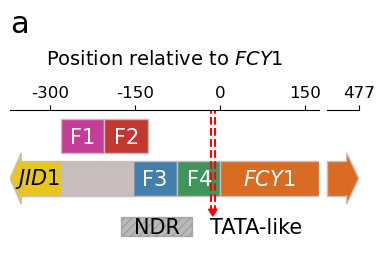

In [39]:
# Panel A: Schematics of the full region
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2),
                        gridspec_kw={'width_ratios': [511, 52]})

fig.subplots_adjust(wspace=0.05)
style_join = 'bevel'  # Does not seem to do anything

# Setting up the ticks and spines to only have annotations at the top of the figure
for ax in axs:
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False,
                  top=True, labeltop=True)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
# Setting the xlims for both parts of the plot
axs[0].set_xlim(left=-371, right=175)  # left is -356 if the first position before the CDS is 0
axs[0].set_ylim(bottom=0, top=4.5)
axs[1].set_xlim(left=425, right=477)
axs[1].set_ylim(bottom=0, top=4.5)

axs[0].tick_params(axis='x', which='major', labelsize=12)
axs[1].tick_params(axis='x', which='major', labelsize=12)

# All the positions need to be rechecked carefully
axs[0].add_patch(Rectangle((-281, 3.25), 77, 1, facecolor='#c43e96',
                          joinstyle=style_join, edgecolor='#c8bdbd')) # F1

axs[0].add_patch(Rectangle((-204, 3.25), 77, 1, facecolor='#c03830',
                          joinstyle=style_join, edgecolor='#c8bdbd')) # F2

axs[0].add_patch(Rectangle((-153, 2), 77, 1, facecolor='#427fac',
                          joinstyle=style_join, edgecolor='#c8bdbd'))  # F3

axs[0].add_patch(Rectangle((-76, 2), 77, 1, facecolor='#3f955a',
                          joinstyle=style_join, edgecolor='#c8bdbd'))  # F4

axs[0].add_patch(Rectangle((1, 2), 174, 1, facecolor='#d45400dc',
                           edgecolor='#c8bdbd', joinstyle=style_join))  # FCY1 CDS

axs[0].add_patch(Rectangle((-351, 2), 69.5, 1, facecolor='#e9c61d',
                          joinstyle=style_join, edgecolor='#c8bdbd')) # JID1 CDS

axs[0].add_patch(Polygon([[-351, 3.25], [-351, 1.75], [-371, 2.5]], facecolor='#e9c61d',
                        joinstyle=style_join, edgecolor='#c8bdbd'))
axs[0].plot([-351, -351], [2.05525, 2.94325], c='white', zorder=2, linewidth=1.40)
axs[0].plot([-351, -351], [2.05525, 2.94325], c='#e9c61d', zorder=3, linewidth=1.50)

# Continuing the FCY1 CDS on the second axis
axs[1].add_patch(Rectangle((425, 2), 32, 1, clip_on=False, facecolor='#d45400dc', 
                           joinstyle=style_join, edgecolor='#c8bdbd'))
axs[1].add_patch(Polygon([[457, 3.25], [457, 1.75], [477, 2.5]], facecolor='#d45400dc',
                         joinstyle=style_join, edgecolor='#c8bdbd'))
axs[1].plot([457, 457], [2.05525, 2.94325], c='white', zorder=2, linewidth=1.40)
axs[1].plot([457, 457], [2.05525, 2.94325], c='#d45400dc', zorder=3, linewidth=1.50)
axs[1].set_xticks([477])  
axs[1].set_xticklabels([477])  

# Adding labels for each element
axs[0].annotate(r"$\it{JID1}$", (-323, 2.5), va="center", ha="center", 
                fontsize=15)

axs[0].annotate('F1', (-242.5, 3.7), va="center", ha="center", 
                fontsize=15, color='white')

axs[0].annotate('F2', (-165.5, 3.7), va="center", ha="center", 
                fontsize=15, color='white')

axs[0].annotate('F3', (-114.5, 2.45), va="center", ha="center", 
                fontsize=15, color='white')

axs[0].annotate('F4', (-36.5, 2.45), va="center", ha="center", 
                fontsize=15, color='white')

axs[0].annotate(r"$\it{FCY1}$", (87.5, 2.45), va="center", ha="center", 
                fontsize=15, color='white')

axs[0].add_patch(Rectangle((-281, 2), 128, 1, clip_on=False, facecolor='#c8bdbd',
                          joinstyle=style_join, edgecolor='#c8bdbd'))  # Intergenic region

# Adding annotation for the TATA-like element and the NDR
# The TATA-like element is at positions -16 to -9 (Rhee et al, 2012)
axs[0].vlines(x=-16, ymin=1.5, ymax=4.5, color='red', linestyle='--')
axs[0].vlines(x=-9, ymin=1.5, ymax=4.5, color='red', linestyle='--')
axs[0].add_patch(Polygon([[-20, 1.6], [-5, 1.6], [-12.5, 1.4]], color='red'))

# The NDR is from -174 to -49, according to Chereji et al. (2018)
axs[0].add_patch(Rectangle((-174, 1.375), 125, -0.55, color='grey', hatch='////', 
                           hatch_linewidth=0.75, alpha=0.55, clip_on=False, zorder=2))


# The most abundant transcript (Pelechano et al, 2013) starts at -28
#axs[0].vlines(x=-28, ymin=1.25, ymax=4.5, color='black', linestyle='--')
#axs[0].add_patch(Polygon([[-35.5, 1.25], [-20.5, 1.25], [-28, 1.15]], color='black'))

# Adding the corresponding labels
axs[0].annotate('TATA-like', (-17, 1.35), va='top', ha='left',
                fontsize=15)
axs[0].annotate('NDR', (-111.5, 1.35), va='top', ha='center',
                fontsize=15)


axs[0].xaxis.set_label_position('top')
axs[0].set_xlabel('Position relative to ' r"$\it{FCY1}$", labelpad=15, fontsize=14)
axs[0].set_xticks([-300, -150, 0, 150])  
axs[0].set_xticklabels([-300, -150, 0, 150])

axs[0].set_title('a', fontsize=22, loc='left', pad=12)

# Saving the figure
Map_S1 = plt.gcf()
Map_S1.savefig('Supp_figs/S1_map.tiff', bbox_inches='tight')

In [19]:
# defining a dictionary of colors
del_palette = {r"$\Delta$F1": '#c43e96',
               r"$\Delta$F2": '#c03830',
               r"$\Delta$F3": '#427fac', 
               r"$\Delta$F4": '#3f955a',
               r"$\Delta$region": '#d45400dc',
               r"$\Delta$F1-F4": '#c8bdbd',
               "Wild-type": 'black'}

crispr_palette = {'F2': '#c03830', 
                  'F4': '#3f955a',
                  'F1-F4': '#c8bdbd',
                  "Wild-type": 'black'}

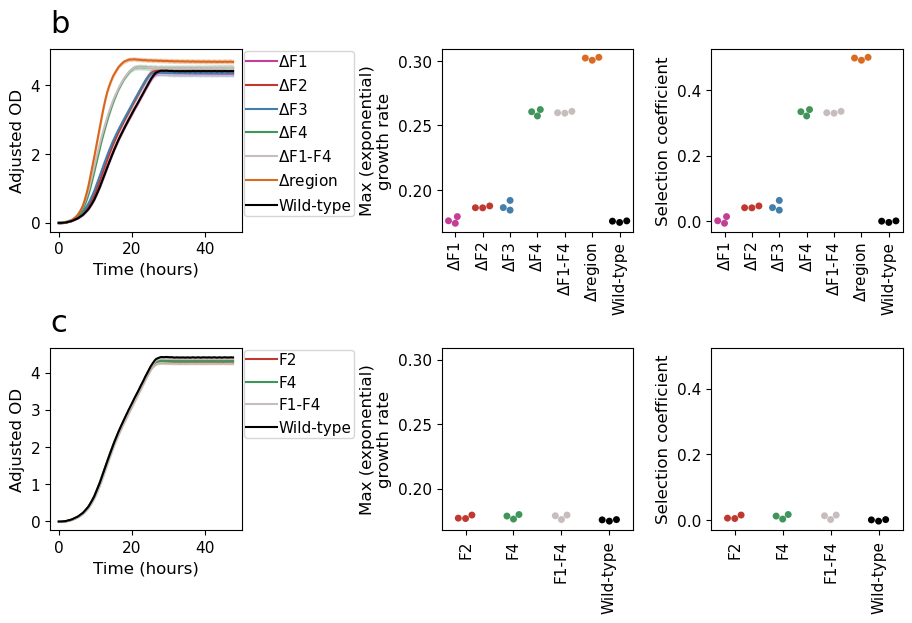

In [20]:
# Panels B and C: Growth phenotypes in 5-FC
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 11

fig = plt.figure(figsize=(11, 6.25))
gs = fig.add_gridspec(5, 35)

ax0 = fig.add_subplot(gs[0:2, 0:8])
ax1 = fig.add_subplot(gs[0:2, 16:24])
ax2 = fig.add_subplot(gs[0:2, 27:35])

ax3 = fig.add_subplot(gs[3:5, 0:8])
ax4 = fig.add_subplot(gs[3:5, 16:24], sharey=ax1)
ax5 = fig.add_subplot(gs[3:5, 27:35], sharey=ax2)

# Adding the plots
sns.lineplot(data=data_5FC_deletions, x='Time (hours)', y='Adj_OD', hue='Strain', palette=del_palette, ax=ax0)
h0, l0 = ax0.get_legend_handles_labels()
ax0.legend(h0, l0, handletextpad=0.1, loc="upper left",
           bbox_to_anchor=(1, 1), borderaxespad=0.15, borderpad=0.15, fontsize=11)
sns.swarmplot(data=rates_deletions, x='Strain', y='Max_log_rate', hue='Strain', palette=del_palette, ax=ax1)
sns.swarmplot(data=rates_deletions, x='Strain', y='s_coeff', hue='Strain', palette=del_palette, ax=ax2)

sns.lineplot(data=data_5FC_crispr, x='Time (hours)', y='Adj_OD', hue='Strain', palette=crispr_palette, ax=ax3)
h3, l3 = ax3.get_legend_handles_labels()
ax3.legend(h3, l3, handletextpad=0.1, loc="upper left",
           bbox_to_anchor=(1, 1), borderaxespad=0.15, borderpad=0.15, fontsize=11)
sns.swarmplot(data=rates_crispr, x='Strain', y='Max_log_rate', hue='Strain', palette=crispr_palette, ax=ax4)
sns.swarmplot(data=rates_crispr, x='Strain', y='s_coeff', hue='Strain', palette=crispr_palette, ax=ax5)

# Adjusting axis ticks and labels
ax0.set_ylabel('Adjusted OD')
ax1.set_ylabel('Max (exponential)\ngrowth rate')
ax2.set_ylabel('Selection coefficient')

ax3.set_ylabel('Adjusted OD')
ax4.set_ylabel('Max (exponential)\ngrowth rate')
ax5.set_ylabel('Selection coefficient')

for ax in [ax1, ax2, ax4, ax5]:
    ax.tick_params(axis='x', labelrotation=90, labelsize=11)
    ax.set_xlabel('')

# Adding letter annotations
ax0.set_title('b', fontsize=22, loc='left', pad=12)
ax3.set_title('c', fontsize=22, loc='left', pad=12)

# Saving the figure
growth_S1 = plt.gcf()
growth_S1.savefig('Supp_figs/S1_growth.tiff', bbox_inches='tight')

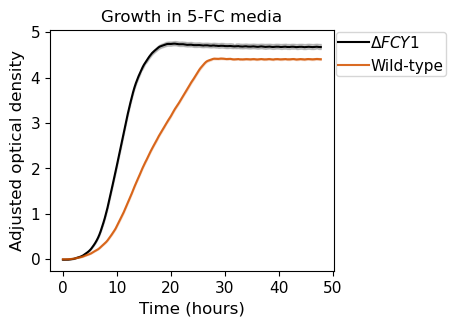

In [21]:
# Making a plot with only growth curves for WT and deletion (for talks)

growth_talk = data_5FC_deletions[data_5FC_deletions['Strain'].isin([r"$\Delta$region", 'Wild-type'])].copy().reset_index(drop=True)
talk_dict = {'Wild-type': 'Wild-type', r"$\Delta$region": r"$\Delta$$\it{FCY1}$"}
growth_talk['Strain'] = growth_talk['Strain'].apply(lambda x: talk_dict[x])

talk_palette = {'Wild-type': '#d45400dc',
                r"$\Delta$$\it{FCY1}$": 'black'}

fig, axs = plt.subplots(1, 1, figsize=(3.66, 3.125))

sns.lineplot(data=growth_talk, x='Time (hours)', y='Adj_OD', hue='Strain', palette=talk_palette, ax=axs)
h0, l0 = axs.get_legend_handles_labels()
axs.legend(h0, l0, handletextpad=0.1, loc="upper left",
           bbox_to_anchor=(1, 1), borderaxespad=0.15, borderpad=0.15, fontsize=11)
axs.set_ylabel('Adjusted optical density')
axs.set_title('Growth in 5-FC media')

# Saving the figure
curves_talk = plt.gcf()
curves_talk.savefig('Prelim_figures/growth_curves_talk.tiff', bbox_inches='tight')